# Starbucks Capstone Challenge

## Contents
1. [Introduction](#Introduction)
2. [Data Sets](#Data-Sets)
3. [Assess data](#Assess-the-data)
4. [Data cleaning](#Clean-the-data)
5. [Modelling](#Modelling)

## Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

In [ ]:
!pip install imblearn
!pip install shap

In [369]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import warnings
import shap

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Assess the data

### Portfolio dataset
Details of each offer sent.

* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [154]:
def assess_data(df, group_by=None):
    '''
    Prints out a number of useful characteristics of a DataFrame, including
    the shape, number of null values, and an optional groupby count.
    
    INPUTS:
    df: pandas DataFrame. The DataFrame to explore.
    group_by: str. A column label to group df by.
    
    RETURNS:
    None
    '''
    print('DataFrame shape: ', df.shape)
    print()
    print('Data types:')
    print(df.dtypes)
    print()
    print('Column stats:')
    print(df.describe())
    print()
    print('Null values:')
    print(df.isnull().sum())
    if group_by:
        print()
        print('Group by {}:'.format(group_by))
        print(df.groupby(group_by).count())

In [155]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [156]:
assess_data(portfolio, 'offer_type')

DataFrame shape:  (10, 6)

Data types:
reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

Column stats:
          reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000

Null values:
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

Group by offer_type :
               reward  channels  difficulty  duration  id
offer_type                                               
bogo                4         4           4         4   4
discount            4         4           4         4   4
informational       2         2           2         2   2


### Profile
Demographic data for each customer.

* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [9]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [149]:
assess_data(profile, 'gender')

DataFrame shape:  (17000, 5)

Data types:
gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

Column stats:
                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000

Null values:
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

Group by  gender
         age    id  became_member_on  income
gender                                      
F       6129  6129              6129    6129
M      

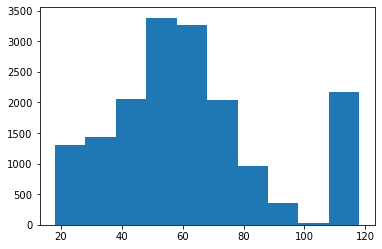

In [157]:
# A max age of 118 is quite high - let's plot a histogram
plt.hist(profile['age']);

In [158]:
# It seems like the age of 188 could represent a null value
# This is supported by the counts matching with the null value counts above
profile[profile['age']==118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

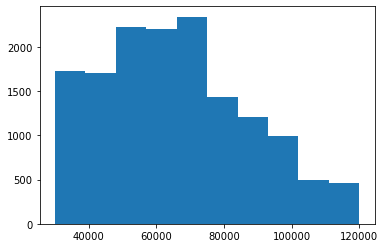

In [159]:
# Let's plot the histogram of income to see if there are issues
# There doesn't seem to be any outliers or suprises
plt.hist(profile['income']);

### Transcript
Records for transactions, offers received, offers viewed, and offers completed.

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [17]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [160]:
assess_data(transcript, 'event')

DataFrame shape:  (306534, 4)

Data types:
person    object
event     object
value     object
time       int64
dtype: object

Column stats:
                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000

Null values:
person    0
event     0
value     0
time      0
dtype: int64

Group by event :
                 person   value    time
event                                  
offer completed   33579   33579   33579
offer received    76277   76277   76277
offer viewed      57725   57725   57725
transaction      138953  138953  138953


In [162]:
# To understand the data more, we can look at all of the events for one user
transcript[transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


## Clean the data

In [366]:
def column_bool(df, column, bool_item):
    '''
    Iterates through the given column in a DataFrame and produces a new column
    populated with 1s if the column contains the desired item.
    
    INPUTS:
    df: pandas DataFrame. The DataFrame that contains the column.
    column: str. The name of the column to iterate through.
    bool_item: str. The name of the item to check for.
    '''
    bool_list = []
    for item in df[column]:
        if bool_item in item:
            bool_list.append(1)
        else:
            bool_list.append(0)
    df[bool_item] = bool_list

In [370]:
# To use in modelling, we need to convert the channel column to dummy variables
for channel in ['web', 'email', 'mobile', 'social']:
    column_bool(portfolio, 'channels', channel)

portfolio.drop('channels', axis=1, inplace=True)
portfolio

,reward,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [371]:
# We also need to do this for the offer_type column
for item in ['bogo', 'informational', 'discount']:
    column_bool(portfolio, 'offer_type', item)
portfolio.drop('offer_type', axis=1, inplace=True)
portfolio

,reward,difficulty,duration,id,web,email,mobile,social,bogo,informational,discount
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,1,0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,0,1
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,0,1
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,0,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,1,0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,0,1


### Profile

In [372]:
# Let's drop the cases where age = 118 since these could be rows with lots of nulls
# This is roughly 13% of users, but we still have 14,825 users
profile.drop(profile[profile['age']==118].index, inplace=True)

In [373]:
# Let's check that all nulls came from the age=118 people
profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [374]:
# The became_member_on column is currently an integer
# To use it in analysis, we should convert it to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'].map(str), format='%Y-%m-%d')
profile.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


In [375]:
# We should convert the gender column to booleans
for gender in ['F', 'M', 'O']:
    column_bool(profile, 'gender', gender)
profile.drop('gender', axis=1, inplace=True)
profile.head()

,age,id,became_member_on,income,F,M,O
1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0
5,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,1,0
8,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,1,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,1,0


### Transcript

In [376]:
# We are just going to be looking at whether an offer is used so we don't need the transaction events
transcript.drop(transcript[transcript['event']=='transaction'].index, inplace=True)

In [377]:
# After dropping transactions, we can pull out the offer ids from the value column
offer = []
for value in transcript['value']:
    offer.append(list(value.values())[0])
transcript['offer'] = offer
transcript.drop('value', axis=1, inplace=True)
transcript.head()

,person,event,time,offer
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In order to model whether an offer will be used or not, we want to create a DataFrame where each existing offer and person combination has just one row. We also want boolean columns indicating whether the offer has been viewed and used.

In [378]:
# In order to combine the rows below, time needs to be a string
transcript['time'] = transcript['time'].apply(lambda x: str(x))
transcript['time']

0           0
1           0
2           0
3           0
4           0
         ... 
306497    714
306506    714
306507    714
306509    714
306527    714
Name: time, Length: 167581, dtype: object

In [379]:
# This creates one row for each person-offer combination and the sequence of events for each combination
event_df = pd.DataFrame(transcript.groupby(['person','offer']).agg({'event': ', '.join, 'time': ', '.join})).reset_index()
event_df.head()

,person,offer,event,time
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,"offer received, offer completed","576, 576"
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,"offer received, offer viewed","336, 372"
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,"offer received, offer viewed","168, 192"
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,"offer received, offer completed, offer viewed","408, 414, 456"
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,"offer received, offer completed, offer viewed","504, 528, 540"


In [380]:
# Check that the merging happened in time order
time_unsorted = []
time_sorted = []
i = 0
while i < len(event_df['time']):
    time_list = event_df['time'][i].split(', ')
    time_list = list(map(int, time_list))
    if time_list == sorted(time_list):
        time_sorted.append(i)
    else:
        time_unsorted.append(i)
    i+=1

In [381]:
# If they are in time order, time_unsorted should be empty
time_unsorted

[]

In [382]:
# We now need to create the boolean columns for the offer being viewed and used
events = event_df['event'].str.split(', ')
received = []
viewed = []
used = []

# This iterates through each person-offer combination present
for event in events:
    # Tries to get the time order of events
    
    # Gets the location of offer received
    try:
        received_loc = event.index('offer received')
    except:
        received_loc = -1
        
    # Gets the location of offer viewed
    try:
        viewed_loc = event.index('offer viewed')
    except:
        viewed_loc = -1
    
    # Gets the location of offer completed
    try:
        completed_loc = event.index('offer completed')
    except:
        completed_loc = -1
    
    # If there is an offer received in the timeline, return 1
    if received_loc >= 0:
        received.append(1)
    else:
        received.append(0)
    
    # If there is an offer viewed in the timeline, return 1
    if viewed_loc >= 0:
        viewed.append(1)
        
        # If viewed_loc is not -1 and the offer viewed happens before the 
        # offer completed, then it returns 1
        # This is to prevent including instances where the offer was completed
        # without viewing the offer (and so unintentionally)
        if viewed_loc < completed_loc:
            used.append(1)
        else:
            used.append(0)
    else:
        viewed.append(0)
        used.append(0)


In [383]:
# Sets the results from the cell above as new columns
event_df['offer_received'] = received
event_df['offer_viewed'] = viewed
event_df['offer_used'] = used
event_df.drop(['event', 'time'], axis=1, inplace=True)
event_df.head()

,person,offer,offer_received,offer_viewed,offer_used
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,0


In [384]:
# Check that every row has had an offer received
event_df.groupby('offer_received').count()

,person,offer,offer_viewed,offer_used
offer_received,,,,
1,63288,63288,63288,63288


In [385]:
# As all of offer_received are 1s, we can drop this column
event_df.drop('offer_received', axis=1, inplace=True)
event_df.head()

,person,offer,offer_viewed,offer_used
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,0


### Merge the datasets

In [386]:
# Merging the event_df and portfolio DataFrames
df = event_df.merge(portfolio, left_on='offer', right_on='id')
df.drop('id', axis=1, inplace=True)
df.head()

,person,offer,offer_viewed,offer_used,reward,difficulty,duration,web,email,mobile,social,bogo,informational,discount
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,0,2,10,7,1,1,1,0,0,0,1
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,0,0,2,10,7,1,1,1,0,0,0,1
2,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,0,0,2,10,7,1,1,1,0,0,0,1
3,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,1,1,2,10,7,1,1,1,0,0,0,1
4,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,1,0,2,10,7,1,1,1,0,0,0,1


In [387]:
# Merging the above with the profile DataFrames
df = df.merge(profile, left_on='person', right_on='id')
df.drop(['id'], axis=1, inplace=True)
df.head()

,person,offer,offer_viewed,offer_used,reward,difficulty,duration,web,email,mobile,social,bogo,informational,discount,age,became_member_on,income,F,M,O
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,0,2,10,7,1,1,1,0,0,0,1,33,2017-04-21,72000.0,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0,0,0,4,1,1,1,0,0,1,0,33,2017-04-21,72000.0,0,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0,0,0,3,0,1,1,1,0,1,0,33,2017-04-21,72000.0,0,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,0,5,5,5,1,1,1,1,1,0,0,33,2017-04-21,72000.0,0,1,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,0,2,10,10,1,1,1,1,0,0,1,33,2017-04-21,72000.0,0,1,0


In [388]:
# Double check there are no nulls
df.isnull().sum()

person              0
offer               0
offer_viewed        0
offer_used          0
reward              0
difficulty          0
duration            0
web                 0
email               0
mobile              0
social              0
bogo                0
informational       0
discount            0
age                 0
became_member_on    0
income              0
F                   0
M                   0
O                   0
dtype: int64

### Feature building

In [389]:
# In the current format, became_member_on is difficult to use in a model
# We can re-format it to be the length of membership as at a certain date
# This date can be the date of the newest member joining, so it will be a measure of relative membership length
latest_join = df['became_member_on'].max()
membership_length = df['became_member_on'].apply(lambda x: latest_join - x).dt.days
df['membership_length'] = membership_length
df.head()

,person,offer,offer_viewed,offer_used,reward,difficulty,duration,web,email,mobile,...,bogo,informational,discount,age,became_member_on,income,F,M,O,membership_length
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,0,2,10,7,1,1,1,...,0,0,1,33,2017-04-21,72000.0,0,1,0,461
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0,0,0,4,1,1,1,...,0,1,0,33,2017-04-21,72000.0,0,1,0,461
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0,0,0,3,0,1,1,...,0,1,0,33,2017-04-21,72000.0,0,1,0,461
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,0,5,5,5,1,1,1,...,1,0,0,33,2017-04-21,72000.0,0,1,0,461
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,0,2,10,10,1,1,1,...,0,0,1,33,2017-04-21,72000.0,0,1,0,461


In [390]:
# We can create a number of new features to hopefully improve accuracy
# Create the squares of features
def col_sq(column, df=df):
    '''
    Takes a column and creates a column of it squared.
    
    INPUTS:
    column: str. The name of the column to be squared.
    df: pandas DataFrame. Contains the column in question and is the destination of the new column.
    
    RETURNS:
    None
    '''
    col_name = column + '_2'
    df[col_name] = df[column] ** 2
    
col_sq('age')
col_sq('reward')
col_sq('difficulty')
col_sq('duration')

# Create the difference between the difficulty and reward
df['reward_difference'] = df['difficulty'] - df['reward']
col_sq('reward_difference')

# Check that it has worked
df.head()

,person,offer,offer_viewed,offer_used,reward,difficulty,duration,web,email,mobile,...,F,M,O,membership_length,age_2,reward_2,difficulty_2,duration_2,reward_difference,reward_difference_2
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,0,2,10,7,1,1,1,...,0,1,0,461,1089,4,100,49,8,64
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0,0,0,4,1,1,1,...,0,1,0,461,1089,0,0,16,0,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0,0,0,3,0,1,1,...,0,1,0,461,1089,0,0,9,0,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,0,5,5,5,1,1,1,...,0,1,0,461,1089,25,25,25,0,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,0,2,10,10,1,1,1,...,0,1,0,461,1089,4,100,100,8,64


In [391]:
# We should normalise the income column
df['income_norm'] = (df['income'] - df['income'].mean())/df['income'].std()
df.head()

,person,offer,offer_viewed,offer_used,reward,difficulty,duration,web,email,mobile,...,M,O,membership_length,age_2,reward_2,difficulty_2,duration_2,reward_difference,reward_difference_2,income_norm
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,0,2,10,7,1,1,1,...,1,0,461,1089,4,100,49,8,64,0.30571
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0,0,0,4,1,1,1,...,1,0,461,1089,0,0,16,0,0,0.30571
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0,0,0,3,0,1,1,...,1,0,461,1089,0,0,9,0,0,0.30571
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,0,5,5,5,1,1,1,...,1,0,461,1089,25,25,25,0,0,0.30571
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,0,2,10,10,1,1,1,...,1,0,461,1089,4,100,100,8,64,0.30571


### Over-sampling

In [392]:
# Check the difference between the number of offers used and unsued
df['offer_viewed'].value_counts()

1    42493
0    12729
Name: offer_viewed, dtype: int64

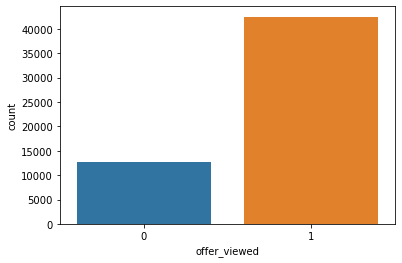

In [393]:
# Although the ratio of c.4:1 is not extreme, it would still improve model accuracy to make it more even
sns.countplot(x = 'offer_viewed', data = df)
plt.show()

In [394]:
# Get list of columns contained in the DataFrame
df.columns

Index(['person', 'offer', 'offer_viewed', 'offer_used', 'reward', 'difficulty',
       'duration', 'web', 'email', 'mobile', 'social', 'bogo', 'informational',
       'discount', 'age', 'became_member_on', 'income', 'F', 'M', 'O',
       'membership_length', 'age_2', 'reward_2', 'difficulty_2', 'duration_2',
       'reward_difference', 'reward_difference_2', 'income_norm'],
      dtype='object')

In [395]:
# Choose the columns to include in y and X
y_column = ['offer_used']
X_columns = ['reward', 'difficulty',
       'duration', 'web', 'mobile', 'social', 'bogo',
       'discount', 'age', 'M', 'O',
       'membership_length', 'age_2', 'reward_2', 'difficulty_2', 'duration_2',
       'reward_difference', 'reward_difference_2', 'income_norm']

In [396]:
# Select the y and X DataFrames
y = df.loc[:, y_column]
X = df.loc[:, X_columns]

In [397]:
# We will now over-sample the unused offer rows to make the proportion equal
# Initiate SMOTE
os = SMOTE()

# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Resample data and convert into DataFrames
os_df_X, os_df_y = os.fit_resample(X_train, y_train)
os_df_X = pd.DataFrame(data=os_df_X, columns=X_columns)
os_df_y= pd.DataFrame(data=os_df_y, columns=y_column)

# Check that the proportion is now equal
print("Proportion of unused offers in oversampled data is ",len(os_df_y[os_df_y['offer_used']==0])/len(os_df_X))
print("Proportion of used offers data in oversampled data is ",len(os_df_y[os_df_y['offer_used']==1])/len(os_df_X))

Proportion of unused offers in oversampled data is  0.5
Proportion of used offers data in oversampled data is  0.5


## Modelling

In [414]:
def logit(y_train, X_train):
    '''
    Fits a Logit model and prints out the summary table.
    
    INPUTS:
    y_train: list. The training set of the dependent variable.
    X_train: pandas DataFrame. The training set of the independent variable.
    
    RETURNS:
    None
    '''
    logit_model = sm.Logit(y_train, X_train)
    fitted_model = logit_model.fit()
    print(fitted_model.summary2())

def logreg(X_train, y_train, X_test):
    '''
    Fits a Logistic Regression and predicts y values. It then prints out the
    confusion matrix and classification report.
    
    INPUTS:
    y_train: list. The training set of the dependent variable.
    X_train: pandas DataFrame. The training set of the independent variables.
    X_test: pandas DataFrame. The test set of the independent variables.
    
    RETURNS:
    logreg: classifier. Fitted Logistic Regression model.
    y_pred: list. Predicted y values from X_test.
    '''
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)

    y_pred = logreg.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    
    return logreg, y_pred

### Base model with new features 

In [399]:
# Fit a logit model
logit(y_train, X_train)

         Current function value: 0.488012
         Iterations: 35
                                Results: Logit
Model:                   Logit                Pseudo R-squared:     0.253     
Dependent Variable:      offer_used           AIC:                  37764.2015
Date:                    2021-08-12 21:12     BIC:                  37918.3253
No. Observations:        38655                Log-Likelihood:       -18864.   
Df Model:                17                   LL-Null:              -25253.   
Df Residuals:            38637                LLR p-value:          0.0000    
Converged:               0.0000               Scale:                1.0000    
No. Iterations:          35.0000                                              
------------------------------------------------------------------------------
                     Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------
reward            

In [409]:
X_columns_base = ['age', 'M', 'O', 'membership_length', 'age_2', 'income_norm']
X = X_train[X_columns_base]
X_test = X_test[X_columns_base]
logreg, y_pred = logreg(X, y_train, X_test)

              precision    recall  f1-score   support

           0       0.65      0.94      0.77     10639
           1       0.46      0.10      0.16      5928

    accuracy                           0.64     16567
   macro avg       0.56      0.52      0.47     16567
weighted avg       0.58      0.64      0.55     16567



### After over-sampling

In [410]:
# Fit a logit model
logit(os_df_y, os_df_X)

         Current function value: 0.459699
         Iterations: 35
                                Results: Logit
Model:                   Logit                Pseudo R-squared:     0.337     
Dependent Variable:      offer_used           AIC:                  45542.6493
Date:                    2021-08-12 21:20     BIC:                  45710.0319
No. Observations:        49494                Log-Likelihood:       -22752.   
Df Model:                18                   LL-Null:              -34307.   
Df Residuals:            49475                LLR p-value:          0.0000    
Converged:               0.0000               Scale:                1.0000    
No. Iterations:          35.0000                                              
------------------------------------------------------------------------------
                     Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------
reward            

In [411]:
# Remove the columns where the p-value is > 0.05
X_columns_updated = ['duration', 'web', 'mobile', 'social',
       'bogo', 'discount', 'age', 'M',
       'membership_length', 'age_2', 'reward_2', 'difficulty_2',
       'duration_2', 'reward_difference_2', 'income_norm']
X = os_df_X[X_columns_updated]
y = os_df_y[y_column]

# Re-fit the logit model
logit(y, X)

Optimization terminated successfully.
         Current function value: 0.548904
         Iterations 6
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.208     
Dependent Variable:  offer_used        AIC:               54364.8800
Date:                2021-08-12 21:22  BIC:               54497.0241
No. Observations:    49494             Log-Likelihood:    -27167.   
Df Model:            14                LL-Null:           -34307.   
Df Residuals:        49479             LLR p-value:       0.0000    
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      6.0000                                         
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
duration            -1.3061   0.0606 -21.5681 0.0000 -1.4247 -1.1874
web                  0.8832 

In [412]:
# Remove the social column as p > 0.05
X_columns_updated = ['duration', 'web', 'mobile',
       'bogo', 'discount', 'age', 'M',
       'membership_length', 'age_2', 'reward_2', 'difficulty_2',
       'duration_2', 'reward_difference_2', 'income_norm']
X = os_df_X[X_columns_updated]
y = os_df_y[y_column]

# Re-fit the logit model
logit(y, X)

Optimization terminated successfully.
         Current function value: 0.548926
         Iterations 6
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.208     
Dependent Variable:  offer_used        AIC:               54365.1052
Date:                2021-08-12 21:23  BIC:               54488.4397
No. Observations:    49494             Log-Likelihood:    -27169.   
Df Model:            13                LL-Null:           -34307.   
Df Residuals:        49480             LLR p-value:       0.0000    
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      6.0000                                         
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
duration            -1.3658   0.0459 -29.7798 0.0000 -1.4556 -1.2759
web                  0.8686 

In [415]:
# Fit logistic regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
logreg, y_pred = logreg(X_train, y_train, X_test)

              precision    recall  f1-score   support

           0       0.69      0.67      0.68      7404
           1       0.68      0.70      0.69      7445

    accuracy                           0.69     14849
   macro avg       0.69      0.69      0.69     14849
weighted avg       0.69      0.69      0.69     14849



### Tuning model

In [318]:
# Set up parameters for GridSearchCV
parameters = {
    'penalty': ['l1', 'l2'],
    'C': [1.0, 6.0],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [1000]
}

In [319]:
# Turns warnings off as the GridSearchCV produces a lot of warnings
# They are around the lbfgs solver not accepting l1 penalty and the liblinear model not converging
warnings.filterwarnings("ignore")

# Run GridSearchCV
clf = GridSearchCV(logreg, param_grid = parameters, cv = 5)
best_clf = clf.fit(X_train, y_train)

In [307]:
# Get predictions from tuned model
y_pred_tuned = clf.predict(X_test)

In [320]:
# Get the optimal parameters from tuned model
clf.best_params_

{'C': 6.0, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}

In [321]:
# Print classification report
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.74      0.69      0.71      7404
           1       0.71      0.76      0.73      7445

    accuracy                           0.72     14849
   macro avg       0.72      0.72      0.72     14849
weighted avg       0.72      0.72      0.72     14849



### Model explanability

In [332]:
# SHAP doesn't allow GridSearchCV objects to be passed through
# I have created a logreg with the optimal parameters from GridSearchCV
logreg_tuned = LogisticRegression(C=6.0, max_iter=1000, penalty='l1', solver='liblinear')

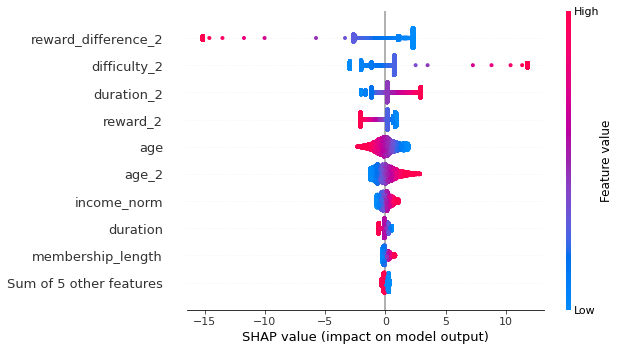

In [333]:
# Initialise SHAP
shap.initjs()

# compute SHAP values
shap_fig = plt.figure()
explainer = shap.Explainer(logreg, X_train)
shap_values = explainer(X_train)

#summary_plot
shap.plots.beeswarm(shap_values)

In [336]:
# Get coefficients from optimised model
coef_dict = {}
for coef, feat in zip(logreg.coef_[0,:],X_columns_updated):
    coef_dict[feat] = coef
coef_dict